<a href="https://colab.research.google.com/github/ashley-lu/Team-BPlate/blob/main/earthquakes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# install packages
!pip install geopandas
!pip install reverse_geocoder

     |████████████████████████████████| 1.0 MB 5.3 MB/s 
     |████████████████████████████████| 15.4 MB 38 kB/s 
     |████████████████████████████████| 6.3 MB 47.3 MB/s 
     |████████████████████████████████| 2.2 MB 5.3 MB/s 
  Created wheel for reverse-geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268087 sha256=1950db7503a21cc3af06ccdd6de7d234d6cebf36bb8b44a9d331ce36faa4a142
  Stored in directory: /root/.cache/pip/wheels/34/6e/70/5423639428a2cac8ea7eb467214a4254b549b381f306a9c790
Successfully built reverse-geocoder


In [7]:
# Python modules
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import reverse_geocoder as rg
import json
import datetime

In [25]:
# upload dataset to Google Colab - run 3 times
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [26]:
df = pd.read_csv(io.BytesIO(uploaded['dataset.csv']))

In [27]:
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2021-10-18T22:00:00.930Z,40.467999,-124.871002,25.90,2.59,md,8.0,325.0,0.47120,0.19,nc,nc73641310,2021-10-19T00:36:12.127Z,"52km WNW of Petrolia, CA",earthquake,14.28,11.58,0.160,3.0,automatic,nc,nc
1,2021-10-18T20:40:39.570Z,37.287498,-120.031502,25.39,2.73,md,8.0,72.0,0.11900,0.08,nc,nc73641270,2021-10-19T00:29:39.269Z,"20km ENE of Le Grand, CA",earthquake,0.60,0.99,0.200,11.0,automatic,nc,nc
2,2021-10-18T10:14:20.120Z,36.809166,-121.546166,0.70,2.81,md,40.0,154.0,0.28730,0.19,nc,nc73641125,2021-10-18T17:05:27.120Z,"4km S of San Juan Bautista, CA",earthquake,0.59,2.25,0.110,41.0,automatic,nc,nc
3,2021-10-18T09:45:06.480Z,36.185833,-120.309167,10.36,3.44,ml,45.0,107.0,0.06493,0.08,nc,nc73641100,2021-10-19T03:24:17.760Z,"7km NE of Coalinga, CA",earthquake,0.22,0.28,0.192,87.0,reviewed,nc,nc
4,2021-10-18T09:42:15.640Z,36.192001,-120.314331,9.70,2.67,md,42.0,106.0,0.10650,0.14,nc,nc73641095,2021-10-18T11:22:59.040Z,"7km NE of Coalinga, CA",earthquake,0.30,0.55,0.170,49.0,automatic,nc,nc


In [28]:
# dropping unnecessary columns
df = df.drop("magType", axis = 1)
df = df.drop("net", axis = 1)
df = df.drop("locationSource", axis = 1)
df = df.drop("magSource", axis = 1)
df = df.drop("id", axis = 1)

In [88]:
df.head()

,time,latitude,longitude,depth,mag,nst,gap,dmin,rms,updated,place,type,horizontalError,depthError,magError,magNst,status
0,2021-10-18T22:00:00.930Z,40.467999,-124.871002,25.90,2.59,8.0,325.0,0.47120,0.19,2021-10-19T00:36:12.127Z,"52km WNW of Petrolia, CA",earthquake,14.28,11.58,0.160,3.0,automatic
1,2021-10-18T20:40:39.570Z,37.287498,-120.031502,25.39,2.73,8.0,72.0,0.11900,0.08,2021-10-19T00:29:39.269Z,"20km ENE of Le Grand, CA",earthquake,0.60,0.99,0.200,11.0,automatic
2,2021-10-18T10:14:20.120Z,36.809166,-121.546166,0.70,2.81,40.0,154.0,0.28730,0.19,2021-10-18T17:05:27.120Z,"4km S of San Juan Bautista, CA",earthquake,0.59,2.25,0.110,41.0,automatic
3,2021-10-18T09:45:06.480Z,36.185833,-120.309167,10.36,3.44,45.0,107.0,0.06493,0.08,2021-10-19T03:24:17.760Z,"7km NE of Coalinga, CA",earthquake,0.22,0.28,0.192,87.0,reviewed
4,2021-10-18T09:42:15.640Z,36.192001,-120.314331,9.70,2.67,42.0,106.0,0.10650,0.14,2021-10-18T11:22:59.040Z,"7km NE of Coalinga, CA",earthquake,0.30,0.55,0.170,49.0,automatic


In [89]:
# missing values
# df[df["nst"].isna()]
# df[df["gap"].isna()]
# df[df["dmin"].isna()]
# df[df["rms"].isna()]
# df[df["place"].isna()]
# df[df["horizontalError"].isna()]
# df[df["magError"].isna()]
# df[df["magNst"].isna()]

df = df.fillna(df.mean())

In [90]:
df.head()

,time,latitude,longitude,depth,mag,nst,gap,dmin,rms,updated,place,type,horizontalError,depthError,magError,magNst,status
0,2021-10-18T22:00:00.930Z,40.467999,-124.871002,25.90,2.59,8.0,325.0,0.47120,0.19,2021-10-19T00:36:12.127Z,"52km WNW of Petrolia, CA",earthquake,14.28,11.58,0.160,3.0,automatic
1,2021-10-18T20:40:39.570Z,37.287498,-120.031502,25.39,2.73,8.0,72.0,0.11900,0.08,2021-10-19T00:29:39.269Z,"20km ENE of Le Grand, CA",earthquake,0.60,0.99,0.200,11.0,automatic
2,2021-10-18T10:14:20.120Z,36.809166,-121.546166,0.70,2.81,40.0,154.0,0.28730,0.19,2021-10-18T17:05:27.120Z,"4km S of San Juan Bautista, CA",earthquake,0.59,2.25,0.110,41.0,automatic
3,2021-10-18T09:45:06.480Z,36.185833,-120.309167,10.36,3.44,45.0,107.0,0.06493,0.08,2021-10-19T03:24:17.760Z,"7km NE of Coalinga, CA",earthquake,0.22,0.28,0.192,87.0,reviewed
4,2021-10-18T09:42:15.640Z,36.192001,-120.314331,9.70,2.67,42.0,106.0,0.10650,0.14,2021-10-18T11:22:59.040Z,"7km NE of Coalinga, CA",earthquake,0.30,0.55,0.170,49.0,automatic


In [91]:
# only "numeric" values
df_numeric = df[["latitude", "longitude", "depth", "mag", "nst", "gap", "dmin", "rms", "horizontalError", "depthError", "magError", "magNst"]]

In [92]:
# checking types
df_numeric.dtypes

latitude           float64
longitude          float64
depth              float64
mag                float64
nst                float64
gap                float64
dmin               float64
rms                float64
horizontalError    float64
depthError         float64
magError           float64
magNst             float64
dtype: object

In [93]:
df_numeric.head()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
0,40.467999,-124.871002,25.90,2.59,8.0,325.0,0.47120,0.19,14.28,11.58,0.160,3.0
1,37.287498,-120.031502,25.39,2.73,8.0,72.0,0.11900,0.08,0.60,0.99,0.200,11.0
2,36.809166,-121.546166,0.70,2.81,40.0,154.0,0.28730,0.19,0.59,2.25,0.110,41.0
3,36.185833,-120.309167,10.36,3.44,45.0,107.0,0.06493,0.08,0.22,0.28,0.192,87.0
4,36.192001,-120.314331,9.70,2.67,42.0,106.0,0.10650,0.14,0.30,0.55,0.170,49.0


In [9]:
from google.colab import files
uploaded = files.upload()

Saving dataset_time.csv to dataset_time (1).csv


In [10]:
df = pd.read_csv("dataset_time.csv")

In [11]:
# add states column to dataset using reverse geocoding
states = []
cities = []
for i in range(len(df)):
  coordinates = (df['latitude'][i], df['longitude'][i])
  res = rg.search(coordinates)
  states.append(res[0]["admin1"])
  cities.append(res[0]["name"])

In [13]:
states_cities = pd.DataFrame({"state" : states, "city" : cities})
df_states = df.join(states_cities)

In [16]:
df_states = df_states.drop("Unnamed: 0", axis = 1)

In [17]:
df_states.head()

,time,latitude,longitude,depth,mag,nst,gap,dmin,rms,updated,place,type,horizontalError,depthError,magError,magNst,status,year,month,day,h:m:s,state,city
0,2021-10-18 22:00:00+00:00,40.467999,-124.871002,25.90,2.59,8.0,325.0,0.47120,0.19,2021-10-19T00:36:12.127Z,"52km WNW of Petrolia, CA",earthquake,14.28,11.58,0.160,3.0,automatic,2021,10,18,22:00:00,California,Ferndale
1,2021-10-18 20:40:39+00:00,37.287498,-120.031502,25.39,2.73,8.0,72.0,0.11900,0.08,2021-10-19T00:29:39.269Z,"20km ENE of Le Grand, CA",earthquake,0.60,0.99,0.200,11.0,automatic,2021,10,18,20:40:39,California,Mariposa
2,2021-10-18 10:14:20+00:00,36.809166,-121.546166,0.70,2.81,40.0,154.0,0.28730,0.19,2021-10-18T17:05:27.120Z,"4km S of San Juan Bautista, CA",earthquake,0.59,2.25,0.110,41.0,automatic,2021,10,18,10:14:20,California,San Juan Bautista
3,2021-10-18 09:45:06+00:00,36.185833,-120.309167,10.36,3.44,45.0,107.0,0.06493,0.08,2021-10-19T03:24:17.760Z,"7km NE of Coalinga, CA",earthquake,0.22,0.28,0.192,87.0,reviewed,2021,10,18,09:45:06,California,Coalinga
4,2021-10-18 09:42:15+00:00,36.192001,-120.314331,9.70,2.67,42.0,106.0,0.10650,0.14,2021-10-18T11:22:59.040Z,"7km NE of Coalinga, CA",earthquake,0.30,0.55,0.170,49.0,automatic,2021,10,18,09:42:15,California,Coalinga


In [18]:
df_states.to_csv("dataset_cleaned.csv", encoding = "utf-8-sig")

In [ ]:
pd.DatetimeIndex(df['time']).time

In [94]:
df['time'] = pd.to_datetime(df['time'])
df['time'] = df['time'].apply(lambda x: x.replace(microsecond = 0))

In [96]:
pd.DatetimeIndex(df['time']).time

array([datetime.time(22, 0), datetime.time(20, 40, 39),
       datetime.time(10, 14, 20), ..., datetime.time(4, 5, 34),
       datetime.time(2, 11, 13), datetime.time(2, 11)], dtype=object)

In [95]:
df.head()

,time,latitude,longitude,depth,mag,nst,gap,dmin,rms,updated,place,type,horizontalError,depthError,magError,magNst,status
0,2021-10-18 22:00:00+00:00,40.467999,-124.871002,25.90,2.59,8.0,325.0,0.47120,0.19,2021-10-19T00:36:12.127Z,"52km WNW of Petrolia, CA",earthquake,14.28,11.58,0.160,3.0,automatic
1,2021-10-18 20:40:39+00:00,37.287498,-120.031502,25.39,2.73,8.0,72.0,0.11900,0.08,2021-10-19T00:29:39.269Z,"20km ENE of Le Grand, CA",earthquake,0.60,0.99,0.200,11.0,automatic
2,2021-10-18 10:14:20+00:00,36.809166,-121.546166,0.70,2.81,40.0,154.0,0.28730,0.19,2021-10-18T17:05:27.120Z,"4km S of San Juan Bautista, CA",earthquake,0.59,2.25,0.110,41.0,automatic
3,2021-10-18 09:45:06+00:00,36.185833,-120.309167,10.36,3.44,45.0,107.0,0.06493,0.08,2021-10-19T03:24:17.760Z,"7km NE of Coalinga, CA",earthquake,0.22,0.28,0.192,87.0,reviewed
4,2021-10-18 09:42:15+00:00,36.192001,-120.314331,9.70,2.67,42.0,106.0,0.10650,0.14,2021-10-18T11:22:59.040Z,"7km NE of Coalinga, CA",earthquake,0.30,0.55,0.170,49.0,automatic


In [97]:
df['year'] = pd.DatetimeIndex(df['time']).year
df['month'] = pd.DatetimeIndex(df['time']).month
df['day'] = pd.DatetimeIndex(df['time']).day
df['h:m:s'] = pd.DatetimeIndex(df['time']).time

In [98]:
df.head()

,time,latitude,longitude,depth,mag,nst,gap,dmin,rms,updated,place,type,horizontalError,depthError,magError,magNst,status,year,month,day,h:m:s
0,2021-10-18 22:00:00+00:00,40.467999,-124.871002,25.90,2.59,8.0,325.0,0.47120,0.19,2021-10-19T00:36:12.127Z,"52km WNW of Petrolia, CA",earthquake,14.28,11.58,0.160,3.0,automatic,2021,10,18,22:00:00
1,2021-10-18 20:40:39+00:00,37.287498,-120.031502,25.39,2.73,8.0,72.0,0.11900,0.08,2021-10-19T00:29:39.269Z,"20km ENE of Le Grand, CA",earthquake,0.60,0.99,0.200,11.0,automatic,2021,10,18,20:40:39
2,2021-10-18 10:14:20+00:00,36.809166,-121.546166,0.70,2.81,40.0,154.0,0.28730,0.19,2021-10-18T17:05:27.120Z,"4km S of San Juan Bautista, CA",earthquake,0.59,2.25,0.110,41.0,automatic,2021,10,18,10:14:20
3,2021-10-18 09:45:06+00:00,36.185833,-120.309167,10.36,3.44,45.0,107.0,0.06493,0.08,2021-10-19T03:24:17.760Z,"7km NE of Coalinga, CA",earthquake,0.22,0.28,0.192,87.0,reviewed,2021,10,18,09:45:06
4,2021-10-18 09:42:15+00:00,36.192001,-120.314331,9.70,2.67,42.0,106.0,0.10650,0.14,2021-10-18T11:22:59.040Z,"7km NE of Coalinga, CA",earthquake,0.30,0.55,0.170,49.0,automatic,2021,10,18,09:42:15


In [99]:
df.to_csv("dataset_time.csv", encoding = "utf-8-sig")

## Correlation Matrix

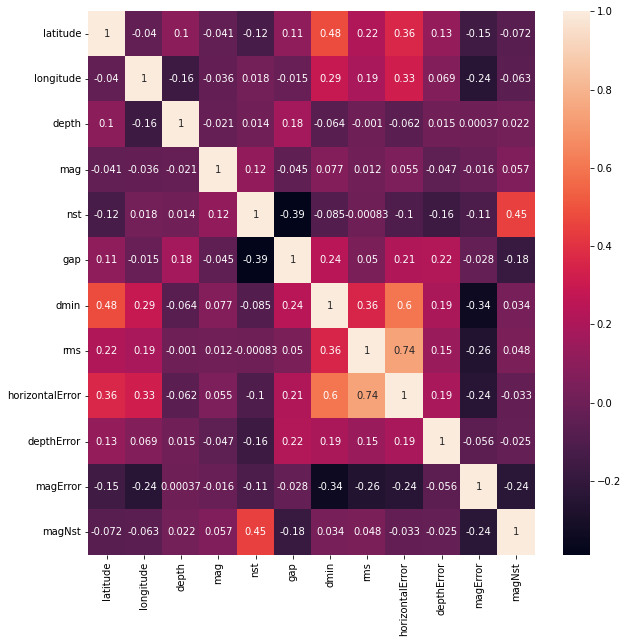

In [ ]:
corr = df_numeric.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    corr, 
    annot = True,
    ax = ax
)

There does not seem to be a strong correlation between any of the variables, with the exception of horizontalError and dmin.

## Other Exploratory Data Analysis
*   Boxplot/histogram with distribution of magnitude
*   Boxplot/histogram with distribution of error margin

## Visualizing Earthquake Locations and Magnitudes

Visualization Ideas:
*   Map with average magnitude per state
*   Map with dots/symbols for each earthquake, colored by magnitude
*   Fault line visualization
*   Top 10 states with highest count of earthquakes/highest magnitude earthquakes



In [ ]:
import reverse_geocoder as rg

In [ ]:
df_states = df.join(states_cities)

In [ ]:
df_states.to_csv("dataset_cleaned.csv", encoding = "utf-8-sig")

In [ ]:
import geopandas as gpd
uploaded = files.upload()

Saving gem_active_faults.geojson to gem_active_faults.geojson


In [ ]:
import json
geodf = gpd.read_file('Qfaults_US_Database.shp')
geodf.to_file("Qfaults_US_Database.geojson", driver = "GeoJSON")
with open("Qfaults_US_Database.geojson") as geofile:
  fault_lines = json.load(geofile)

In [ ]:
import json
with open("gem_active_faults.geojson") as geofile:
  fault_lines = json.load(geofile)

In [ ]:
fault_lines["features"][0].keys()

dict_keys(['type', 'properties', 'geometry'])

In [ ]:
for k in range(len(fault_lines['features'])):
    fault_lines['features'][k]['id'] = k

In [ ]:
len(fault_lines['features'])

16195

In [ ]:
fault_lines["features"]["id"]

TypeError: ignored

In [ ]:
fig = px.choropleth_mapbox(df_states, geojson=fault_lines, locations=[i for i in range(0, 16196)], color='mag',
                           color_continuous_scale="Viridis",
                           range_color=(0, 12),
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5)
fig.show()

ValueError: ignored

## Time Analysis
*   Animated earthquakes over time
*   Count of earthquakes for time of day
*   Visualizing number of earthquakes per month - is there an earthquake season?